In [49]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
from GPy.kern import Kern
from GPy import Param, Model

In [50]:
class RationalQuadratic(Kern):
    
    def __init__(self,input_dim,variance=1.,lengthscale=1.,power=1.,active_dims=None):
        super(RationalQuadratic, self).__init__(input_dim, active_dims, 'rat_quad')
        assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.variance = Param('variance', variance)
        self.lengthscale = Param('lengtscale', lengthscale)
        self.power = Param('power', power)
        self.link_parameters(self.variance, self.lengthscale, self.power)
    
    def parameters_changed(self):
        # nothing todo here
        pass
    
    def K(self,X,X2):
        if X2 is None: X2 = X
        dist2 = np.square((X-X2.T)/self.lengthscale1)
        return self.variance*(1 + dist2/2.)**(-self.power)
    
    def Kdiag(self,X):
        return self.variance*np.ones(X.shape[0])
    
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X
        dist2 = np.square((X-X2.T)/self.lengthscale)

        dvar = (1 + dist2/2.)**(-self.power)
        dl = self.power * self.variance * dist2 * self.lengthscale**(-3) * (1 + dist2/2./self.power)**(-self.power-1)
        dp = - self.variance * np.log(1 + dist2/2.) * (1 + dist2/2.)**(-self.power)

        self.variance.gradient = np.sum(dvar*dL_dK)
        self.lengthscale.gradient = np.sum(dl*dL_dK)
        self.power.gradient = np.sum(dp*dL_dK)
        
    def update_gradients_diag(self, dL_dKdiag, X):
        self.variance.gradient = np.sum(dL_dKdiag)
        # here self.lengthscale and self.power have no influence on Kdiag so target[1:] are unchanged
        
    def gradients_X(self,dL_dK,X,X2):
        """derivative of the covariance matrix with respect to X."""
        if X2 is None: X2 = X
        dist2 = np.square((X-X2.T)/self.lengthscale)

        dX = -self.variance*self.power * (X-X2.T)/self.lengthscale**2 *  (1 + dist2/2./self.lengthscale)**(-self.power-1)
        return np.sum(dL_dK*dX,1)[:,None]
    
    def gradients_X_diag(self,dL_dKdiag,X):
        # no diagonal gradients
        pass
    


In [51]:
import pods

In [52]:
data = pods.datasets.olympic_marathon_men()

In [53]:
m1 = GPy.models.GPRegression(data['X'], data['Y'])

In [54]:
m1.kern.lengthscale = 10.
m1.optimize('bfgs', max_iters=200)

{'dataplot': [<matplotlib.collections.PathCollection at 0x1a290b4cf8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a29111710>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a28c15710>]}

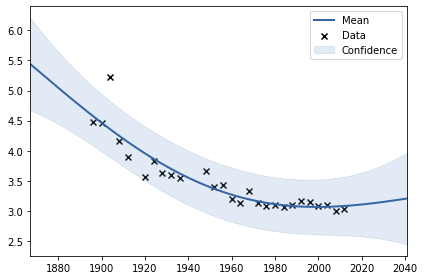

In [55]:
m1.plot()

In [56]:
kern_test = RationalQuadratic(input_dim=1)

In [57]:
m2 = GPy.models.GPRegression(data['X'], data['Y'], kern_test)
#m2.kern.lengthscale = 1.5

In [58]:
m2.optimize('bfgs', max_iters=200)

{'dataplot': [<matplotlib.collections.PathCollection at 0x1a28f7bbe0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a29111748>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a28f8b2e8>]}

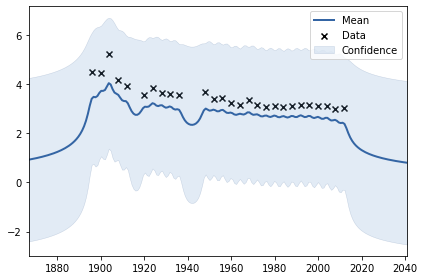

In [59]:
m2.plot()

In [60]:
print(m2)


Name : GP regression
Objective : 59.94905598182413
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rat_quad.variance        |  1.6843263453015926  |               |        
  rat_quad.lengtscale      |   1.345631872456057  |               |        
  rat_quad.power           |  0.4399738012653436  |               |        
  Gaussian_noise.variance  |  1.2096104343735088  |      +ve      |        


In [61]:
print(m1)


Name : GP regression
Objective : 6.947137912153204
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |     25.39950481233699  |      +ve      |        
  rbf.lengthscale          |    152.04531326794887  |      +ve      |        
  Gaussian_noise.variance  |  0.048506474758299216  |      +ve      |        
